# ANTICIPEZ LES BESOINS EN CONSOMMATION DES BATIMENTS 

### Contexte
**Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.**

### Mission
- **Prédiction des émissions de CO2 et de la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées à partir de relevés minutieux effectués en 2016.**
- **Evaluation de  l’intérêt de l’ENERGY STAR Score pour la prédiction d’émissions (calcul fastidieux), intégration dans la modélisation et jugement de son intérêt.**

### A noter
**Concernant la modélisation, elle sera réalisée de la même manière que pour la prédiction de l'émission de gaz à effet de serre. Ainsi, 3 jeux seront créés: les jeux de test et d'entrainement pour la mise en place du modèle et un jeu de validation permettant d'évaluer la qualité de l'apprentissage.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Data split
from sklearn.model_selection import train_test_split

# Train time
import time

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Métrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# Cross Validation
from sklearn.model_selection import cross_val_score, GridSearchCV
import shap

from scipy.stats import skewtest


In [2]:
# Ouverture de dataframe pour la modélisation
filename = pd.read_csv("jeu_modelisation.csv")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
filename.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),AgePropriete,Entrepôts réfrigérés et Data Center,Education,Stockage,Parking,Activités sociales,Santé et Recherche,Hébergement,Gros commerces,Usines,Bureaux,Petits commerces,Autre et services,Restauration,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia and queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,1.0,12,88434.0,60.0,84.300003,2.83,27.730164,54.605997,17.663840,96,0.0,0.0,0.0,0.000000,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1.0,11,103566.0,61.0,97.900002,2.86,0.000000,38.660907,61.339093,27,0.0,0.0,0.0,14.545314,0.0,0.0,80.991831,0.0,0.0,0.0,0.0,0.0,4.462855,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.0,41,953211.0,43.0,97.699997,2.19,29.711310,68.230746,2.057944,54,0.0,0.0,0.0,20.637403,0.0,0.0,79.362597,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,10,61320.0,56.0,113.300003,4.67,32.591348,40.751933,26.656720,97,0.0,0.0,0.0,0.000000,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1.0,18,191454.0,75.0,118.699997,2.88,0.000000,37.880171,62.119829,43,0.0,0.0,0.0,35.522371,0.0,0.0,64.477629,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0


In [3]:
# Copie du fichier
df = filename.copy()

In [4]:
# Infos sur le jeu de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NumberofBuildings                     967 non-null    float64
 1   NumberofFloors                        967 non-null    int64  
 2   PropertyGFATotal                      967 non-null    float64
 3   ENERGYSTARScore                       967 non-null    float64
 4   SiteEUIWN(kBtu/sf)                    967 non-null    float64
 5   GHGEmissionsIntensity                 967 non-null    float64
 6   SteamUse(%)                           967 non-null    float64
 7   Electricity(%)                        967 non-null    float64
 8   NaturalGas(%)                         967 non-null    float64
 9   AgePropriete                          967 non-null    int64  
 10  Entrepôts réfrigérés et Data Center   967 non-null    float64
 11  Education          

In [5]:
# Ouverture de dataframe pour la validation
file = pd.read_csv("jeu_validation.csv")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
file.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(%),Electricity(%),NaturalGas(%),AgePropriete,Entrepôts réfrigérés et Data Center,Education,Stockage,Parking,Activités sociales,Santé et Recherche,Hébergement,Gros commerces,Usines,Bureaux,Petits commerces,Autre et services,Restauration,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia and queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,1.0,2,126028.0,NaN,141.600006,3.10,0.000000,60.988402,39.011598,24,0.000000,0.0,0.0,29.515663,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,70.484337,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1.0,8,102761.0,NaN,68.800003,2.16,36.142257,57.741817,6.115926,97,0.000000,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.0,11,414987.0,NaN,51.099998,0.44,3.967751,96.032249,0.000000,19,0.258803,0.0,0.0,11.807599,0.000000,0.0,0.0,0.0,0.0,0.000000,87.933598,0.000000,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,6,130000.0,NaN,78.400002,4.18,46.124599,44.733739,9.141662,93,0.000000,0.0,0.0,0.000000,69.230769,0.0,0.0,0.0,0.0,30.769231,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1.0,5,57452.0,NaN,137.100006,4.75,23.352383,49.497101,27.150516,116,0.000000,0.0,0.0,0.000000,28.618673,0.0,0.0,0.0,0.0,16.955023,0.000000,0.000000,26.987746,0,0,0,1,0,0,0,0,0,0,0,0,0


In [6]:
# Copie du fichier
validation = file.copy()

In [7]:
# Infos sur le jeu de données
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NumberofBuildings                     516 non-null    float64
 1   NumberofFloors                        516 non-null    int64  
 2   PropertyGFATotal                      516 non-null    float64
 3   ENERGYSTARScore                       0 non-null      float64
 4   SiteEUIWN(kBtu/sf)                    516 non-null    float64
 5   GHGEmissionsIntensity                 516 non-null    float64
 6   SteamUse(%)                           516 non-null    float64
 7   Electricity(%)                        516 non-null    float64
 8   NaturalGas(%)                         516 non-null    float64
 9   AgePropriete                          516 non-null    int64  
 10  Entrepôts réfrigérés et Data Center   516 non-null    float64
 11  Education          

# Prédiction de l'intensité de l'émission des gaz à effet de serre

## 1. Préparation des données

### 1.1. Séparation du jeu de données 

In [8]:
X = df.drop(['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', "ENERGYSTARScore"], axis=1)
y = df["GHGEmissionsIntensity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Vérification des dimensions 
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (773, 33)
X_test: (194, 33)
y_train: (773,)
y_test: (194,)


### 1.2. Fonction de passage de la target y à l'échelle logarithmique

In [10]:
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

## 2. Modélisations sans l'Energy Star Score

**Les modèles testés dans ce notebook seront les mêmes que ceux utilisés pour la prédiction de la consommation en énergie, modèles non sensibles au scaling des données, et ce en suivant la même démarche.**

**Pour rappel:**
- **Le modèle de Régression Linaire pour établir une baseline**
- **3 modèles de régression linéaire: Les modèles Lasso, Ridge et ElasticNet**
- **3 méthodes ensemblistes de régression non linéaires: Les RandomForestRegressor, GradientBoostingRegressor et XGBRegressor.**

### 2.1. Modélisation sans recherche de paramètres

**1. LISTE DES MODELES A TESTER**

In [11]:
models = [LinearRegression(), Ridge(random_state=42), Lasso(random_state=42), ElasticNet(random_state=42), 
          RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42), XGBRegressor()]

**2. CREATION D'UNE FONCTION POUR COMPARER L'ENSEMBLE DES MODELES EN UNE FOIS SANS RECHERCHE DE PARAMETRES**

In [12]:
def basic_gas(models):
    '''Comparaison des différents modèles pour la prédiction de l'intensité de l'émission des gaz à effet de serre'''
    
    print('Comparaison des différents modèles pour la prédiction \n de l\'intensité de l\'émission des gaz à effet de serre') 
 
    cols = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'RFR', 'GBR', 'XGBR']
    index = ['Training Time', 'Train R²','Train RMSE', 'Train MSE', 'Train MAE', 'Test R²','Test RMSE', 'Test MSE', 'Test MAE']
    
    results_standard = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    
    start_time = time.time()
    for model in models:
        model_regressor = TransformedTargetRegressor(regressor=model, transformer=transformer)
        model_fit = model_regressor.fit(X_train, y_train)
        model_y_pred_train = model_regressor.predict(X_train)
        model_y_pred_test = model_regressor.predict(X_test)

        results_standard.iloc[0,col] = time.time() - start_time
        
        results_standard.iloc[1,col] = r2_score(y_train, model_y_pred_train)
        results_standard.iloc[2,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        results_standard.iloc[3,col] = mean_squared_error(y_train, model_y_pred_train)
        results_standard.iloc[4,col] = mean_absolute_error(y_train, model_y_pred_train) 
        
        results_standard.iloc[5,col] = r2_score(y_test,model_y_pred_test)
        results_standard.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        results_standard.iloc[7,col] = mean_squared_error(y_test, model_y_pred_test)
        results_standard.iloc[8,col] = mean_absolute_error(y_test, model_y_pred_test)
       
        col += 1

    return results_standard

In [13]:
results_standard = basic_gas(models=models)
results_standard

Comparaison des différents modèles pour la prédiction 
 de l'intensité de l'émission des gaz à effet de serre


,LinearRegression,Ridge,Lasso,ElasticNet,RFR,GBR,XGBR
Training Time,0.01301,0.016727,0.028735,0.033494,0.457,0.582772,1.205339
Train R²,0.624847,0.625227,0.534675,0.576581,0.911985,0.82556,0.996601
Train RMSE,1.042625,1.042096,1.161187,1.107666,0.505013,0.710963,0.099248
Train MSE,1.087068,1.085965,1.348356,1.226925,0.255038,0.505468,0.00985
Train MAE,0.540101,0.539771,0.599104,0.57187,0.21878,0.368146,0.047067
Test R²,0.477957,0.489518,0.455774,0.521177,0.741191,0.760482,0.714724
Test RMSE,0.905172,0.895092,0.924202,0.866893,0.637334,0.613121,0.66913
Test MSE,0.819336,0.80119,0.85415,0.751503,0.406195,0.375918,0.447735
Test MAE,0.448059,0.446534,0.480689,0.455982,0.377495,0.371699,0.405424


**CONCLUSION: Concernant les méthodes ensemblistes, nous sommes déjà en présence de résultats très prometteurs sans réglage de paramètres. Néanmoins, un passage via GridSearchCV sera effectué afin d'effectuer à minima des cross-validation.**

### 2.2. Modélisation avec recherche de paramètres via GridSearchCV

**1. RECHERCHE DES PARAMETRES POUR CHAQUE MODELE**

**La baseline**

In [14]:
# Il n'existe pas de paramètres pour la régression linéaire
baseline_1 = LinearRegression()

**Le modèle Ridge**

In [15]:
ridge = Ridge(normalize=True, random_state=42)

# Définir la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
ridge_regressor = TransformedTargetRegressor(regressor=ridge, transformer=transformer)

# Dictionnaire des paramètres testés
ridge_param = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'regressor__max_iter': [10, 100, 200, 400, 600, 800, 1000]}

# Recherche des meilleurs paramètres
grid_ridge = GridSearchCV(ridge_regressor, param_grid= ridge_param, cv = 5, scoring='r2')
grid_ridge.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_ridge = grid_ridge.best_params_
best_param_ridge

{'regressor__alpha': 0.1, 'regressor__max_iter': 10}

In [16]:
ridge_1 = Ridge(alpha=0.1, max_iter=10, random_state=42, normalize=True)

*Le cv_results avec les meilleurs hyperparamètres*

In [17]:
ridge = Ridge(normalize=True, random_state=42)

# Définir la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
ridge_regressor = TransformedTargetRegressor(regressor=ridge, transformer=transformer)

# Dictionnaire des paramètres testés
ridge_param = {'regressor__alpha': [0.1], 'regressor__max_iter': [10]}

# Recherche des meilleurs paramètres
grid_ridge = GridSearchCV(ridge_regressor, param_grid= ridge_param, cv = 5, scoring='r2')
grid_ridge.fit(X_train, y_train)

# cv_results
grid_ridge.cv_results_

{'mean_fit_time': array([0.00446782]),
 'std_fit_time': array([0.00580473]),
 'mean_score_time': array([0.00370932]),
 'std_score_time': array([0.00323561]),
 'param_regressor__alpha': masked_array(data=[0.1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_regressor__max_iter': masked_array(data=[10],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'regressor__alpha': 0.1, 'regressor__max_iter': 10}],
 'split0_test_score': array([0.53050534]),
 'split1_test_score': array([0.64826457]),
 'split2_test_score': array([0.54023809]),
 'split3_test_score': array([0.64432061]),
 'split4_test_score': array([0.51327999]),
 'mean_test_score': array([0.57532172]),
 'std_test_score': array([0.05860043]),
 'rank_test_score': array([1])}

**Le modèle Lasso**

In [18]:
'''lasso = Lasso(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
lasso_regressor = TransformedTargetRegressor(regressor=lasso, transformer=transformer)

# Dictionnaire des paramètres testés
lasso_param = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'regressor__max_iter': [2000, 5000, 10000, 1000000]}

# Recherche des meilleurs paramètres
grid_lasso = GridSearchCV(lasso_regressor, param_grid= lasso_param, cv = 5, scoring='r2')
grid_lasso.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_lasso = grid_lasso.best_params_
best_param_lasso'''

"lasso = Lasso(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nlasso_regressor = TransformedTargetRegressor(regressor=lasso, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nlasso_param = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'regressor__max_iter': [2000, 5000, 10000, 1000000]}\n\n# Recherche des meilleurs paramètres\ngrid_lasso = GridSearchCV(lasso_regressor, param_grid= lasso_param, cv = 5, scoring='r2')\ngrid_lasso.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_lasso = grid_lasso.best_params_\nbest_param_lasso"

Ouput de la recherche: {'regressor__alpha': 0.01, 'regressor__max_iter': 2000}

In [19]:
lasso_1 = Lasso(alpha=0.01, max_iter=2000, random_state=42, normalize=True)

**L'elasticNet**

In [20]:
'''el = ElasticNet(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
el_regressor = TransformedTargetRegressor(regressor=el, transformer=transformer)

# Dictionnaire des paramètres testés
el_param = {'regressor__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'regressor__alpha':[100, 10 ,1 , 0.1, 0.01, 0.001], 'regressor__max_iter': [1000, 2000, 5000]}

# Recherche des meilleurs paramètres
grid_el = GridSearchCV(el_regressor, param_grid= el_param, cv = 5, scoring='r2')
grid_el.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_el = grid_el.best_params_
best_param_el'''

"el = ElasticNet(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nel_regressor = TransformedTargetRegressor(regressor=el, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nel_param = {'regressor__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'regressor__alpha':[100, 10 ,1 , 0.1, 0.01, 0.001], 'regressor__max_iter': [1000, 2000, 5000]}\n\n# Recherche des meilleurs paramètres\ngrid_el = GridSearchCV(el_regressor, param_grid= el_param, cv = 5, scoring='r2')\ngrid_el.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_el = grid_el.best_params_\nbest_param_el"

Output de la recherche : {'regressor__alpha': 0.01,
 'regressor__l1_ratio': 0.3,
 'regressor__max_iter': 1000}

In [21]:
el_1 = ElasticNet(alpha=0.01, max_iter= 1000, l1_ratio=0.3, random_state=42)

**Le Random Forest Regressor**

In [22]:
"""rfr = RandomForestRegressor(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
rfr_regressor = TransformedTargetRegressor(regressor=rfr, transformer=transformer)

# Dictionnaire des paramètres testés
rfr_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], 
             'regressor__max_depth': [5, 10, 15,20], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_rfr = GridSearchCV(rfr_regressor, param_grid= rfr_param, cv = 5, scoring='r2', n_jobs= -1)
grid_rfr.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_rfr = grid_rfr.best_params_
best_param_rfr"""

"rfr = RandomForestRegressor(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nrfr_regressor = TransformedTargetRegressor(regressor=rfr, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nrfr_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], \n             'regressor__max_depth': [5, 10, 15,20], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_rfr = GridSearchCV(rfr_regressor, param_grid= rfr_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_rfr.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_rfr = grid_rfr.best_params_\nbest_param_rfr"

Output de la recherche: {'regressor__criterion': 'absolute_error','regressor__max_depth': 20,'regressor__max_features': 'sqrt','regressor__n_estimators': 100}

In [23]:
rfr_1 = RandomForestRegressor(criterion= 'absolute_error', max_depth=20, max_features= 'sqrt', n_estimators = 100, random_state=42)

**Le Gradient Boosting Regressor**

In [24]:
'''gbr = GradientBoostingRegressor(random_state=42)

# Définition la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
gbr_regressor = TransformedTargetRegressor(regressor=gbr, transformer=transformer)

# Dictionnaire des paramètres testés
gbr_param = {'regressor__n_estimators': [50, 100, 200, 400, 1000], 'regressor__max_features': ['sqrt', 'log2'], 
             'regressor__max_depth': [5, 10, 15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_gbr = GridSearchCV(gbr_regressor, param_grid= gbr_param, cv = 5, scoring='r2', n_jobs= -1)
grid_gbr.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_gbr = grid_gbr.best_params_
best_param_gbr'''

"gbr = GradientBoostingRegressor(random_state=42)\n\n# Définition la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\ngbr_regressor = TransformedTargetRegressor(regressor=gbr, transformer=transformer)\n\n# Dictionnaire des paramètres testés\ngbr_param = {'regressor__n_estimators': [50, 100, 200, 400, 1000], 'regressor__max_features': ['sqrt', 'log2'], \n             'regressor__max_depth': [5, 10, 15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_gbr = GridSearchCV(gbr_regressor, param_grid= gbr_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_gbr.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_gbr = grid_gbr.best_params_\nbest_param_gbr"

Output de la recherche: {'regressor__criterion': 'absolute_error', 'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 100}

In [25]:
gbr_1 = GradientBoostingRegressor(criterion='absolute_error', max_depth=5, max_features="sqrt", n_estimators=100, random_state=42)

**Le XGBRegressor**

In [26]:
'''xgbr = XGBRegressor()

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
xgbr_regressor = TransformedTargetRegressor(regressor=xgbr, transformer=transformer)

# Dictionnaire des paramètres testés
xgbr_param = {'regressor__n_estimators':[10,50,100,500,1000], 'regressor__max_depth': [2,4,8,16]}

# Recherche des meilleurs paramètres
grid_xgbr = GridSearchCV(xgbr_regressor, param_grid= xgbr_param, cv = 5, scoring='r2', n_jobs= -1)
grid_xgbr.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_xgbr = grid_xgbr.best_params_
best_param_xgbr'''

"xgbr = XGBRegressor()\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nxgbr_regressor = TransformedTargetRegressor(regressor=xgbr, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nxgbr_param = {'regressor__n_estimators':[10,50,100,500,1000], 'regressor__max_depth': [2,4,8,16]}\n\n# Recherche des meilleurs paramètres\ngrid_xgbr = GridSearchCV(xgbr_regressor, param_grid= xgbr_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_xgbr.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_xgbr = grid_xgbr.best_params_\nbest_param_xgbr"

Output de la recherche = {'regressor__max_depth': 2, 'regressor__n_estimators': 50}

In [27]:
xgbr_1 = XGBRegressor(max_depth=2, n_estimators=50, random_state=42)

**2. LISTE DES MODELES OPTIMISES**

In [28]:
optimized_models = [baseline_1, ridge_1, lasso_1, el_1, rfr_1 ,gbr_1, xgbr_1]

**3. CREATION D'UNE FONCTION POUR COMPARER L'ENSEMBLE DES MODELES EN UNE FOIS APRES GRIDSEARCHCV**

In [29]:
def optimized_gas(models):
    '''Comparaison des différents modèles pour la prédiction de l'intensité de l'émission des gaz à effet de serre'''
    
    print('Comparaison des différents modèles pour la prédiction \n de l\'intensité de l\'émission des gaz à effet de serre après GridSearchCV') 
 
    cols = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'RFR', 'GBR', 'XGBR']
    index = ['Grid Training Time', 'Grid Train R²','Grid Train RMSE', 'Grid Train MSE', 'Grid Train MAE', 'Grid Test R²','Grid Test RMSE', 'Grid Test MSE', 'Grid Test MAE']
    
    results_optimized = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    
    start_time = time.time()
    for model in optimized_models:
        model_fit = model.fit(X_train, y_train)
        model_y_pred_train = model.predict(X_train)
        model_y_pred_test = model.predict(X_test)

        results_optimized.iloc[0,col] = time.time() - start_time
        
        results_optimized.iloc[1,col] = r2_score(y_train, model_y_pred_train)
        results_optimized.iloc[2,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        results_optimized.iloc[3,col] = mean_squared_error(y_train, model_y_pred_train)
        results_optimized.iloc[4,col] = mean_absolute_error(y_train, model_y_pred_train)
        
        results_optimized.iloc[5,col] = r2_score(y_test,model_y_pred_test)
        results_optimized.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        results_optimized.iloc[7,col] = mean_squared_error(y_test, model_y_pred_test)
        results_optimized.iloc[8,col] = mean_absolute_error(y_test, model_y_pred_test)
       
        col += 1

    return results_optimized

In [30]:
results_optimized = optimized_gas(models=optimized_models)
results_optimized

Comparaison des différents modèles pour la prédiction 
 de l'intensité de l'émission des gaz à effet de serre après GridSearchCV


,LinearRegression,Ridge,Lasso,ElasticNet,RFR,GBR,XGBR
Grid Training Time,0.008048,0.02528,0.029827,0.096135,1.274874,5.232662,5.342513
Grid Train R²,0.637779,0.633705,0.486115,0.636281,0.939131,0.902864,0.813935
Grid Train RMSE,1.024497,1.030242,1.220273,1.026614,0.419974,0.530536,0.73427
Grid Train MSE,1.049593,1.061399,1.489066,1.053936,0.176378,0.281469,0.539152
Grid Train MAE,0.601932,0.593388,0.729805,0.598232,0.22999,0.262768,0.435181
Grid Test R²,0.540722,0.57977,0.494271,0.546846,0.74221,0.732488,0.713737
Grid Test RMSE,0.849015,0.812122,0.890915,0.843335,0.636078,0.647961,0.670287
Grid Test MSE,0.720827,0.659542,0.79373,0.711215,0.404595,0.419854,0.449284
Grid Test MAE,0.550068,0.53361,0.630064,0.545772,0.42279,0.403539,0.444862


**4. CONCATENATION DES DATAFRAMES AVANT ET APRES OPTIMISATION**

In [31]:
# Concaténation des 2 dataframes
gas = pd.concat([results_standard ,results_optimized ], axis=0)

# Réarrangement du dataframe pour une meilleure clarté
print('Comparaison des différents modèles pour la prédiction de l\'intensité \n de l\'émission des gaz à effet de serre')
gas = gas.reindex(['Training Time' ,'Grid Training Time', 'Train R²','Grid Train R²', 'Train RMSE','Grid Train RMSE', 'Train MSE','Grid Train MSE', 'Train MAE','Grid Train MAE', 'Test R²','Grid Test R²', 'Test MSE','Grid Test MSE', 'Test MAE','Grid Test MAE'])
gas

Comparaison des différents modèles pour la prédiction de l'intensité 
 de l'émission des gaz à effet de serre


,LinearRegression,Ridge,Lasso,ElasticNet,RFR,GBR,XGBR
Training Time,0.01301,0.016727,0.028735,0.033494,0.457,0.582772,1.205339
Grid Training Time,0.008048,0.02528,0.029827,0.096135,1.274874,5.232662,5.342513
Train R²,0.624847,0.625227,0.534675,0.576581,0.911985,0.82556,0.996601
Grid Train R²,0.637779,0.633705,0.486115,0.636281,0.939131,0.902864,0.813935
Train RMSE,1.042625,1.042096,1.161187,1.107666,0.505013,0.710963,0.099248
Grid Train RMSE,1.024497,1.030242,1.220273,1.026614,0.419974,0.530536,0.73427
Train MSE,1.087068,1.085965,1.348356,1.226925,0.255038,0.505468,0.00985
Grid Train MSE,1.049593,1.061399,1.489066,1.053936,0.176378,0.281469,0.539152
Train MAE,0.540101,0.539771,0.599104,0.57187,0.21878,0.368146,0.047067
Grid Train MAE,0.601932,0.593388,0.729805,0.598232,0.22999,0.262768,0.435181


**CONCLUSION SUR LES RESULTATS: Parmi tous les modèles testés, les 3 méthodes ensemblistes sont clairement les plus performantes.**

**CHOIX DU MODELE: Pour la prédiction de la consommation de l'intensité de l'émission de gaz à effet de serre, les modèles RandomForestRegressor et le GradientBoostingRegressor semblent davantage prometteurs. De ce fait, une nouvelle recherche de paramètres sera effectuée sur ces 2 modèles.**

## 2.3. Nouvelle recherche de paramètres pour les 2 méthodes ensemblistes

### 1. Le Random Forest Regressor

In [32]:
'''rfr_2 = RandomForestRegressor(random_state=42)

# Définition de la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
rfr_2_regressor = TransformedTargetRegressor(regressor=rfr_2, transformer=transformer)

# Dictionnaire des paramètres testés
rfr_2_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], 
             'regressor__max_depth': [15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_rfr_2 = GridSearchCV(rfr_2_regressor, param_grid= rfr_2_param, cv = 5, scoring='r2', n_jobs= -1)
grid_rfr_2.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_rfr_2 = grid_rfr_2.best_params_
best_param_rfr_2'''

"rfr_2 = RandomForestRegressor(random_state=42)\n\n# Définition de la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\nrfr_2_regressor = TransformedTargetRegressor(regressor=rfr_2, transformer=transformer)\n\n# Dictionnaire des paramètres testés\nrfr_2_param = {'regressor__n_estimators': [50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], \n             'regressor__max_depth': [15, 20, 25], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_rfr_2 = GridSearchCV(rfr_2_regressor, param_grid= rfr_2_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_rfr_2.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_rfr_2 = grid_rfr_2.best_params_\nbest_param_rfr_2"

output ='regressor__criterion': 'absolute_error','regressor__max_depth': 25,'regressor__max_features': 'sqrt','regressor__n_estimators': 100}

In [33]:
rfr_2 = RandomForestRegressor(criterion= 'absolute_error', max_depth=25, max_features= 'sqrt', n_estimators = 100, random_state=42)

### 2. Le Gradient Boosting Regressor

In [34]:
'''gbr_2 = GradientBoostingRegressor(random_state=42)

# Définir la fonction de transformation logarithmique
transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)

# Passage au log de la Target
gbr_2_regressor = TransformedTargetRegressor(regressor=gbr_2, transformer=transformer)

# Dictionnaire des paramètres testés
gbr_2_param = {'regressor__n_estimators': [25, 50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], 
             'regressor__max_depth': [2, 4, 8, 16], 'regressor__criterion':['squared_error', 'absolute_error']}

# Recherche des meilleurs paramètres
grid_gbr_2 = GridSearchCV(gbr_2_regressor, param_grid= gbr_2_param, cv = 5, scoring='r2', n_jobs= -1)
grid_gbr_2.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_param_gbr_2 = grid_gbr_2.best_params_
best_param_gbr_2'''

"gbr_2 = GradientBoostingRegressor(random_state=42)\n\n# Définir la fonction de transformation logarithmique\ntransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)\n\n# Passage au log de la Target\ngbr_2_regressor = TransformedTargetRegressor(regressor=gbr_2, transformer=transformer)\n\n# Dictionnaire des paramètres testés\ngbr_2_param = {'regressor__n_estimators': [25, 50, 100, 200, 400], 'regressor__max_features': ['sqrt', 'log2'], \n             'regressor__max_depth': [2, 4, 8, 16], 'regressor__criterion':['squared_error', 'absolute_error']}\n\n# Recherche des meilleurs paramètres\ngrid_gbr_2 = GridSearchCV(gbr_2_regressor, param_grid= gbr_2_param, cv = 5, scoring='r2', n_jobs= -1)\ngrid_gbr_2.fit(X_train, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_gbr_2 = grid_gbr_2.best_params_\nbest_param_gbr_2"

output = {'regressor__criterion': 'squared_error','regressor__max_depth': 2, 'regressor__max_features': 'sqrt','regressor__n_estimators': 400}

In [35]:
gbr_2 = GradientBoostingRegressor(criterion='squared_error', max_depth=2, max_features="sqrt", n_estimators=400, random_state=42)

In [36]:
choix = [rfr_1, rfr_2, gbr_1, gbr_2]

### 3. Fonction permettant la comparaison des 2 modèles avec la nouvelle recherche de paramètres

In [37]:
def choice_gas(models):
    '''Comparaison des différents modèles pour la prédiction de l'intensité de l'émission des gaz à effet de serre'''
    
    print('Choix du modèle pour la prédiction \n de l\'intensité de l\'émission des gaz à effet de serre après GridSearchCV') 
 
    cols = ['RFR 1', 'RFR 2', 'GBR 1', 'GBR 2']
    index = ['Grid Training Time', 'Grid Train R²','Grid Train RMSE', 'Grid Train MSE', 'Grid Train MAE', 'Grid Test R²','Grid Test RMSE', 'Grid Test MSE', 'Grid Test MAE']
    
    results_choice = pd.DataFrame(index=index, columns=cols)
    
    
    col = 0
    
    start_time = time.time()
    for model in choix:
        model_fit = model.fit(X_train, y_train)
        model_y_pred_train = model.predict(X_train)
        model_y_pred_test = model.predict(X_test)
        
        results_choice.iloc[0,col] = time.time() - start_time
        
        results_choice.iloc[1,col] = r2_score(y_train, model_y_pred_train)
        results_choice.iloc[2,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        results_choice.iloc[3,col] = mean_squared_error(y_train, model_y_pred_train)
        results_choice.iloc[4,col] = mean_absolute_error(y_train, model_y_pred_train)
        
        results_choice.iloc[5,col] = r2_score(y_test,model_y_pred_test)
        results_choice.iloc[6,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        results_choice.iloc[7,col] = mean_squared_error(y_test, model_y_pred_test)
        results_choice.iloc[8,col] = mean_absolute_error(y_test, model_y_pred_test)
       
        col += 1

    return results_choice

In [38]:
results_choice = choice_gas(models=choix)
results_choice

Choix du modèle pour la prédiction 
 de l'intensité de l'émission des gaz à effet de serre après GridSearchCV


,RFR 1,RFR 2,GBR 1,GBR 2
Grid Training Time,3.246331,6.456486,10.141948,10.415677
Grid Train R²,0.939131,0.942969,0.902864,0.883486
Grid Train RMSE,0.419974,0.406518,0.530536,0.58105
Grid Train MSE,0.176378,0.165257,0.281469,0.337619
Grid Train MAE,0.22999,0.21641,0.262768,0.365437
Grid Test R²,0.74221,0.737025,0.732488,0.713738
Grid Test RMSE,0.636078,0.642444,0.647961,0.670284
Grid Test MSE,0.404595,0.412734,0.419854,0.449281
Grid Test MAE,0.42279,0.422229,0.403539,0.463936


**MODELE RETENU: Le Random Forest Regressor avec la 1ère recherche d'hyperparamètres, présentant de meilleures métriques sur le jeu test. De plus, de dernier est le plus rapide à entraîner.**

## 3. Le Random Forest Regressor

### 3.1. L'apprentissage du modèle

In [39]:
# Description de la variable 'GHGEmissionsIntensity'
df["GHGEmissionsIntensity"].describe()

count    967.000000
mean       1.334654
std        1.626537
min        0.010000
25%        0.330000
50%        0.730000
75%        1.680000
max       13.880000
Name: GHGEmissionsIntensity, dtype: float64

In [40]:
# Entrainement du modèle
rfr_1.fit(X_train,y_train)

# Prédiction sur les données d'entrainement
y_rfr_train = rfr_1.predict(X_train)

# Prédiction sur les données test
y_rfr_test = rfr_1.predict(X_test)

# Scores sur les 2 jeux
rfr_score_train = rfr_1.score(X_train, y_train)
rfr_score_test = rfr_1.score(X_test, y_test)

In [41]:
print(f'Train score: {rfr_score_train}')
print(f'Test score:  {rfr_score_test}')

Train score: 0.939130803231092
Test score:  0.7422103406407878


**1. COMPARAISON DES VALEURS PREDITES ET DES VALEURS REELLES**

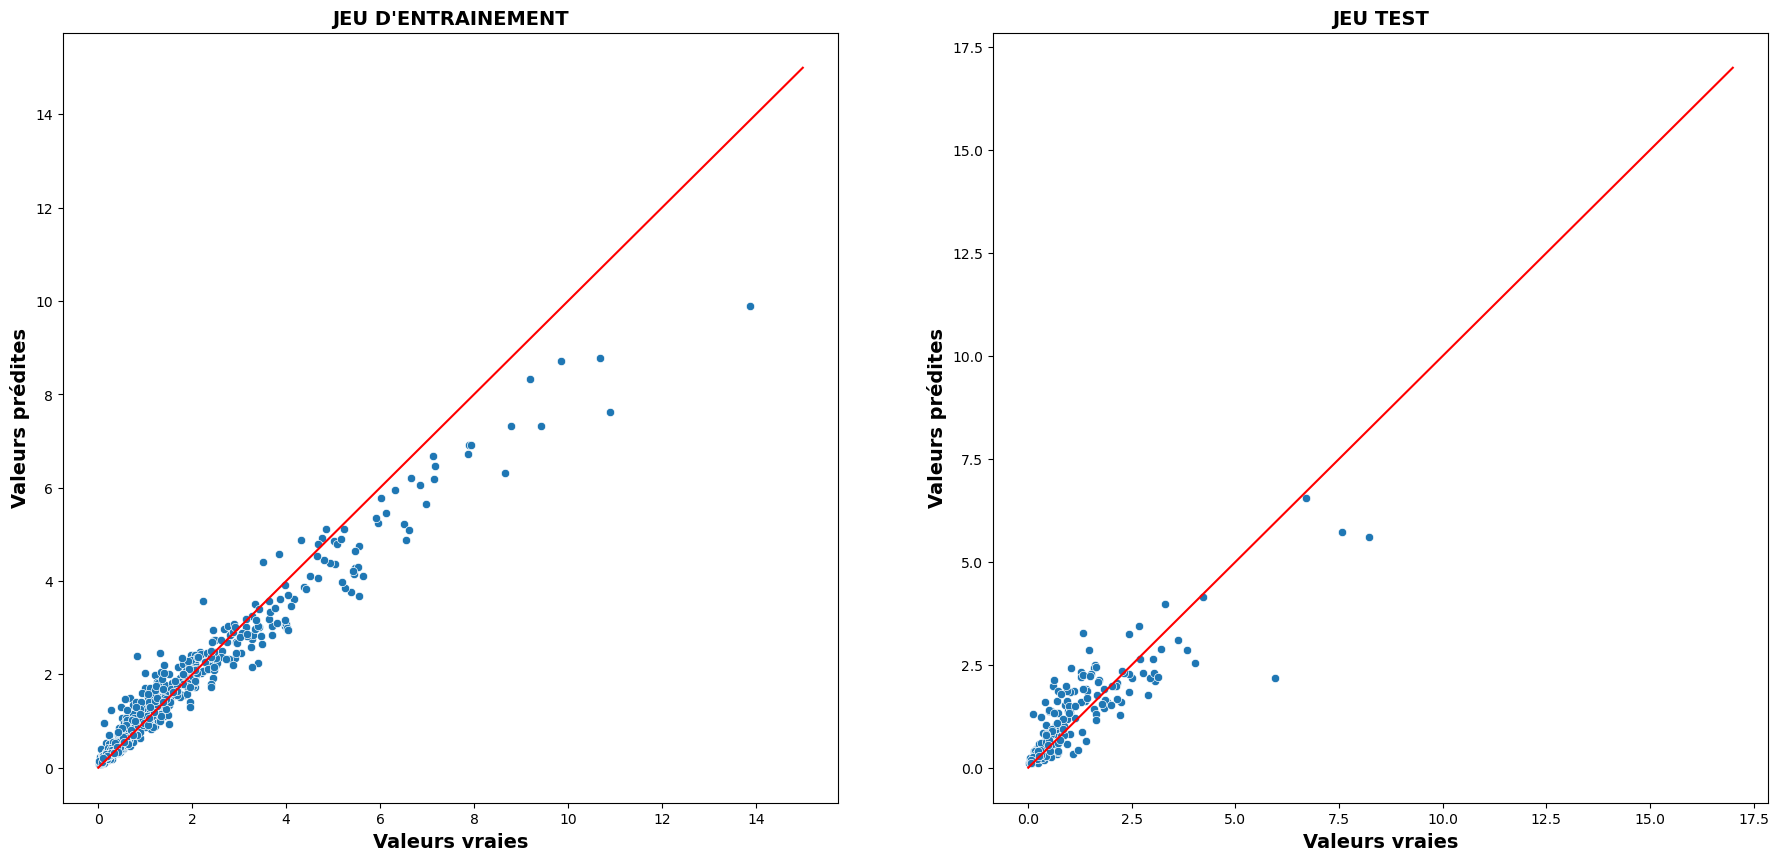

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (22,10))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax=axes[0], x=y_train, y= y_rfr_train)
    sns.lineplot(ax=axes[0], x=np.linspace(0, 15, 50), y=np.linspace(0, 15, 50), color='r')
    axes[0].set_xlabel("Valeurs vraies", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_ylabel("Valeurs prédites", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_title("JEU D'ENTRAINEMENT", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.scatterplot(ax=axes[1], x=y_test, y= y_rfr_test)
    sns.lineplot(ax=axes[1], x=np.linspace(0, 17, 50), y=np.linspace(0, 17, 50), color='r')
    axes[1].set_xlabel("Valeurs vraies", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_ylabel("Valeurs prédites", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_title("JEU TEST", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    
plt.show()

**2. DISTRIBUTION DES ERREURS**

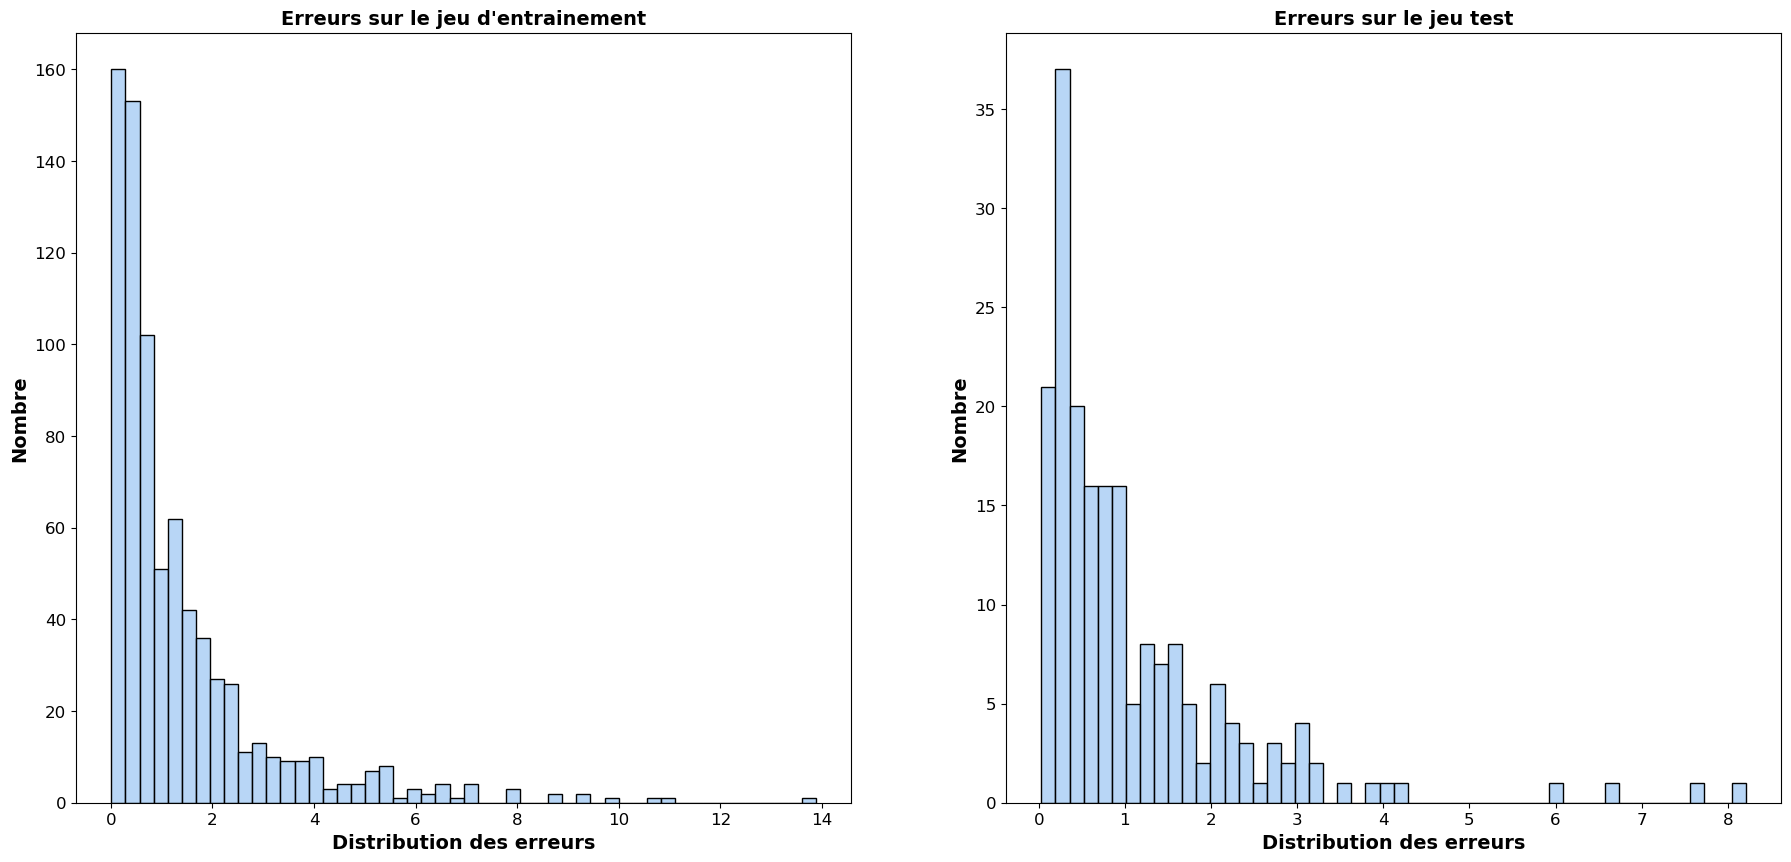

In [43]:
errors_train = np.abs(y_train, y_rfr_train)
errors_test = np.abs(y_test, y_rfr_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (22,10))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.histplot(ax=axes[0], x=errors_train, bins=50)
    axes[0].set_xlabel("Distribution des erreurs", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_ylabel("Nombre", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[0].set_title("Erreurs sur le jeu d'entrainement", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.histplot(ax=axes[1], x=errors_test, bins=50)
    axes[1].set_xlabel("Distribution des erreurs", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_ylabel("Nombre", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    axes[1].set_title("Erreurs sur le jeu test", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    
plt.show()

**CONCLUSION: Avec le peu de données que nous possédons, je trouve que le modèle est globalement satisfaisant, et ce surtout en regardant la distribution des erreurs. En effet, les erreurs réalisées ne sont pas d'une grande ampleur.**

### 3.2. L'apprentissage des variables

**1. IMPORTANCE DES VARIABLES SUR L'ENTRAINEMENT DU MODELE: feature_importances**

**Récupération de l'importance des variables sous forme d'array**

In [44]:
# Sous forme d'array
rfr_1_importances = rfr_1.feature_importances_
print(rfr_1_importances)

# Transformation en pd.Series
rfr_importances = pd.Series(rfr_1_importances)

[0.01350559 0.04899891 0.07536761 0.03491426 0.22170139 0.17365272
 0.06798259 0.00130011 0.00706247 0.02470625 0.03491223 0.00096821
 0.02662062 0.02545762 0.08603573 0.00027486 0.03495419 0.01252017
 0.01476603 0.00426599 0.00884321 0.00353941 0.0043728  0.00783991
 0.01153167 0.0078021  0.00620103 0.00860555 0.00338597 0.00838059
 0.00756379 0.00553961 0.0064268 ]


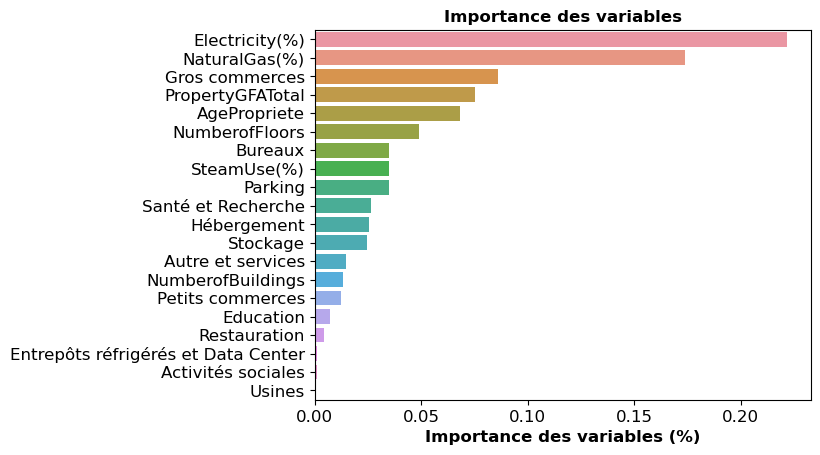

In [45]:
importances = rfr_importances.head(20)
idx = X.columns

i, v =[],[]
for i_0, v_0 in sorted(zip(importances, idx), reverse =True):
    i.append(i_0)
    v.append(v_0)
    with sns.color_palette(palette="pastel"):
        plt.rcParams.update({"font.size":12})
        sns.barplot(x=i, y=v)
        plt.xlabel("Importance des variables (%)", fontname="sans-serif", fontsize=12, fontweight="bold")
        plt.xlim()
        plt.xticks()
        plt.title("Importance des variables", fontname="sans-serif", fontsize=12, fontweight="bold")
    
plt.show()

**CONCLUSION SUR L'IMPORTANCE DES VARIABLES POUR L'ENTRAINEMENT DU MODELE**
**Les 10 fearures les plus importantes sont respectivement:**
- **La part d'électricité en % dans les énergies utilisées**
- **La part de gaz naturel en % dans les énergies utilisées**
- **Le secteur des gros commerces**
- **La superficie totale de la propriété**
- **L'âge de la propriété**
- **Le nombre d'étages**
- **La part de vapeur en % dans les énergies utilisées**
- **Les bureaux**
- **Le parking**
- **Le secteur de la Santé en Recherche**

**2. IMPORTANCE DES VARIABLES SUR LA PREDICTION DU MODELE: LES VALEURS DE SHAPLEY**

**Elles permettent, pour une observation donnée, de quantifier l'impact de chaque feature de cette observation sur la prédiction qui lui est associée par le modèle.**

In [46]:
# Fits the explainer
explainer = shap.TreeExplainer(rfr_1)

# Calculates the SHAP values - It takes some time
shap_values = explainer.shap_values(X_train)

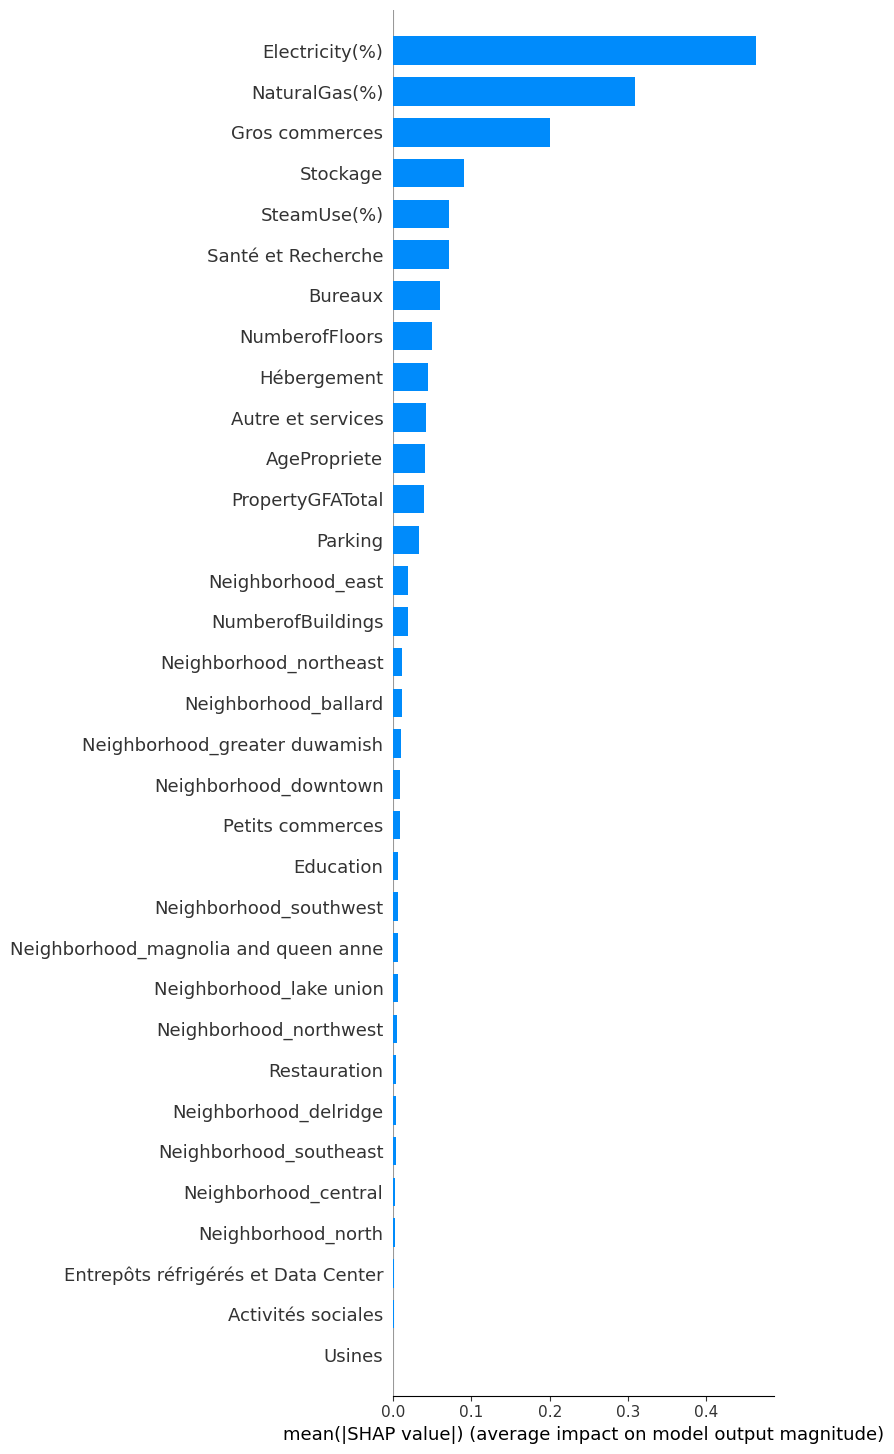

In [47]:
shap.summary_plot(shap_values, feature_names=X.columns, plot_type='bar', max_display=33)

**CONCLUSION SUR L'IMPORTANCE DES VARIABLES POUR L'ENTRAINEMENT DU MODELE**

**Les 10 features contribuant en moyenne le plus à la prédiction du modèle sont respectivement:**
- **La part d'électricité en % dans les énergies utilisées**
- **La part de gaz naturel en % dans les énergies utilisées**
- **Le secteur des gros commerces**
- **Le secteur des entrepôts**
- **Le secteur de la Santé en Recherche**
- **La part de vapeur en % dans les énergies utilisées**
- **Les bureaux**
- **Le secteur de l'hébergement
- **Le nombre d'étages**
- **L'âge de la propriété**

## 3. Impact de l'ajout de Energy Star Score dans la modélisation du Random Forest Regressor

In [48]:
# Copie du jeu de données de modélisation
star_score = filename.copy()

In [49]:
# Infos sur le jeu de données
star_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NumberofBuildings                     967 non-null    float64
 1   NumberofFloors                        967 non-null    int64  
 2   PropertyGFATotal                      967 non-null    float64
 3   ENERGYSTARScore                       967 non-null    float64
 4   SiteEUIWN(kBtu/sf)                    967 non-null    float64
 5   GHGEmissionsIntensity                 967 non-null    float64
 6   SteamUse(%)                           967 non-null    float64
 7   Electricity(%)                        967 non-null    float64
 8   NaturalGas(%)                         967 non-null    float64
 9   AgePropriete                          967 non-null    int64  
 10  Entrepôts réfrigérés et Data Center   967 non-null    float64
 11  Education          

## 3.1. Séparation du jeu de données

In [50]:
X_star = star_score.drop(["SiteEUIWN(kBtu/sf)", "GHGEmissionsIntensity"], axis=1)
y_star = star_score["GHGEmissionsIntensity"]

X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_star, y_star, test_size=0.2, random_state=42)

In [51]:
# Vérification des dimensions 
print(f'X_train_star: {X_train_star.shape}')
print(f'X_test_star: {X_test_star.shape}')
print(f'y_train_star: {y_train_star.shape}')
print(f'y_test_star: {y_test_star.shape}')

X_train_star: (773, 34)
X_test_star: (194, 34)
y_train_star: (773,)
y_test_star: (194,)


## 3.2. Modélisation

**Afin de faciliter la comparaison des modèles avec et sans EnergyStarScore, le modèle entrainé précedemment sera ré-entrainé.**

**1. MODELISATION SANS L'ENERGY STAR SCORE**

In [52]:
no_star_rfr= RandomForestRegressor(criterion= 'absolute_error', max_depth=20, max_features= 'sqrt', n_estimators = 100, random_state=42)

In [53]:
no_star_rfr =  [no_star_rfr]

In [54]:
def no_star_gas(models):

    print("Prédiction de l'intensité de l'émission des gaz à effet de serre \n sans l'Energy Star Score")

    col_base = ['RFR sans EnergyStarScore']
    index_base = ['Train R²','Train RMSE', 'Train MSE', 'Train MAE', 'Test R²','Test RMSE', 'Test MSE', 'Test MAE']

    no_star = pd.DataFrame(index=index_base, columns=col_base)

    col = 0

    for model in no_star_rfr:
        model_fit = model.fit(X_train,y_train)
        model_y_pred_train = model.predict(X_train)
        model_y_pred_test = model.predict(X_test)
    
        
        no_star.iloc[0,col] = r2_score(y_train, model_y_pred_train)
        no_star.iloc[1,col] = np.sqrt(mean_squared_error(y_train, model_y_pred_train))
        no_star.iloc[2,col] = mean_squared_error(y_train, model_y_pred_train)
        no_star.iloc[3,col] = mean_absolute_error(y_train, model_y_pred_train)
        no_star.iloc[4,col] = r2_score(y_test, model_y_pred_test)
        no_star.iloc[5,col] = np.sqrt(mean_squared_error(y_test, model_y_pred_test))
        no_star.iloc[6,col] = mean_squared_error(y_test, model_y_pred_test)
        no_star.iloc[7,col] = mean_absolute_error(y_test, model_y_pred_test)
    
        col +=1 
       
    return no_star

In [55]:
no_star = no_star_gas(models= no_star_rfr)
no_star

Prédiction de l'intensité de l'émission des gaz à effet de serre 
 sans l'Energy Star Score


,RFR sans EnergyStarScore
Train R²,0.939131
Train RMSE,0.419974
Train MSE,0.176378
Train MAE,0.22999
Test R²,0.74221
Test RMSE,0.636078
Test MSE,0.404595
Test MAE,0.42279


**2. MODELISATION AVEC L'ENERGY STAR SCORE**

In [56]:
star_rfr = RandomForestRegressor(criterion= 'absolute_error', max_depth=20, max_features= 'sqrt', n_estimators = 100, random_state=42)

In [57]:
star_rfr = [star_rfr]

In [58]:
def star_gas(models):

    print("Prédiction de l'intensité de l'émission des gaz à effet de serre \n avec l'Energy Star Score")

    col_base = ['RFR avec EnergyStarScore']
    index_base = ['Train R²','Train RMSE', 'Train MSE', 'Train MAE', 'Test R²','Test RMSE', 'Test MSE', 'Test MAE']

    results_star = pd.DataFrame(index=index_base, columns=col_base)

    col = 0

    for model in star_rfr:
        model_fit = model.fit(X_train_star,y_train_star)
        model_y_pred_train_star = model.predict(X_train_star)
        model_y_pred_test_star = model.predict(X_test_star)
    
        
        results_star.iloc[0,col] = r2_score(y_train_star, model_y_pred_train_star)
        results_star.iloc[1,col] = np.sqrt(mean_squared_error(y_train_star, model_y_pred_train_star))
        results_star.iloc[2,col] = mean_squared_error(y_train_star, model_y_pred_train_star)
        results_star.iloc[3,col] = mean_absolute_error(y_train_star, model_y_pred_train_star)
        results_star.iloc[4,col] = r2_score(y_test_star, model_y_pred_test_star)
        results_star.iloc[5,col] = np.sqrt(mean_squared_error(y_test_star, model_y_pred_test_star))
        results_star.iloc[6,col] = mean_squared_error(y_test_star, model_y_pred_test_star)
        results_star.iloc[7,col] = mean_absolute_error(y_test_star, model_y_pred_test_star)
    
        col +=1 
       
    return results_star

In [59]:
results_star = star_gas(models=star_rfr)
results_star

Prédiction de l'intensité de l'émission des gaz à effet de serre 
 avec l'Energy Star Score


,RFR avec EnergyStarScore
Train R²,0.948906
Train RMSE,0.384776
Train MSE,0.148053
Train MAE,0.196019
Test R²,0.777909
Test RMSE,0.590395
Test MSE,0.348566
Test MAE,0.365365


**3. CONCATENATION DES 2 DATAFRAMES**

In [60]:
interet_star = pd.concat([no_star, results_star], axis = 1)
interet_star

,RFR sans EnergyStarScore,RFR avec EnergyStarScore
Train R²,0.939131,0.948906
Train RMSE,0.419974,0.384776
Train MSE,0.176378,0.148053
Train MAE,0.22999,0.196019
Test R²,0.74221,0.777909
Test RMSE,0.636078,0.590395
Test MSE,0.404595,0.348566
Test MAE,0.42279,0.365365


**CONCLUSION: L'Energy Star Score améliore les performances, et ce notamment sur le jeu test...**

# 4. La prédiction sur de nouvelles données

## 4.1. L'apprentissage du modèle 

### 1. Entrainement du modèle sur de nouvelles données

In [61]:
# Description de la target
validation["GHGEmissionsIntensity"].describe()

count    516.000000
mean       2.086531
std        2.680087
min        0.010000
25%        0.495000
50%        1.170000
75%        2.410000
max       16.990000
Name: GHGEmissionsIntensity, dtype: float64

In [62]:
X_val = validation.drop(["SiteEUIWN(kBtu/sf)", "GHGEmissionsIntensity", "ENERGYSTARScore"], axis=1)
y_val = validation["GHGEmissionsIntensity"]

In [63]:
rfr_val = RandomForestRegressor(criterion= 'absolute_error', max_depth=20, max_features= 'sqrt', n_estimators = 100, random_state=42)

In [64]:
# Entrainement du modèle
rfr_val.fit(X_val,y_val)

# Prédiction sur le jeu d'évaluation
y_pred_val = rfr_val.predict(X_val)

# Scores sur le jeu de validation
score_r2_val = rfr_val.score(X_val, y_val)
score_RMSE_val = np.sqrt(mean_squared_error(y_val,y_pred_val))
score_MSE_val = mean_squared_error(y_val, y_pred_val)
score_MAE_val = mean_absolute_error(y_val, y_pred_val)

print(f'R²: {score_r2_val}')
print(f'RMSE: {score_RMSE_val}')
print(f'MSE: {score_MSE_val}')
print(f'MAE: {score_MAE_val}')

R²: 0.9028826989512889
RMSE: 0.8344032771331279
MSE: 0.6962288288905035
MAE: 0.49247897286821696


In [65]:
# Pourcentage d'erreurs du modèle

print(1-rfr_val.score(X_val, y_val))

0.09711730104871108


### 2. Comparaison des valeurs prédites et des valeurs réelles

In [66]:
y_vrai = pd.DataFrame(y_val)
y_predit = pd.DataFrame(y_pred_val)

data_plot = pd.concat([y_vrai, y_predit], axis = 1)
data_plot.rename(columns={"GHGEmissionsIntensity": "y_vrai", 0: "y_predit"}, inplace = True)
data_plot.head()

,y_vrai,y_predit
0,3.10,2.44525
1,2.16,2.72095
2,0.44,0.56330
3,4.18,4.21360
4,4.75,4.34770


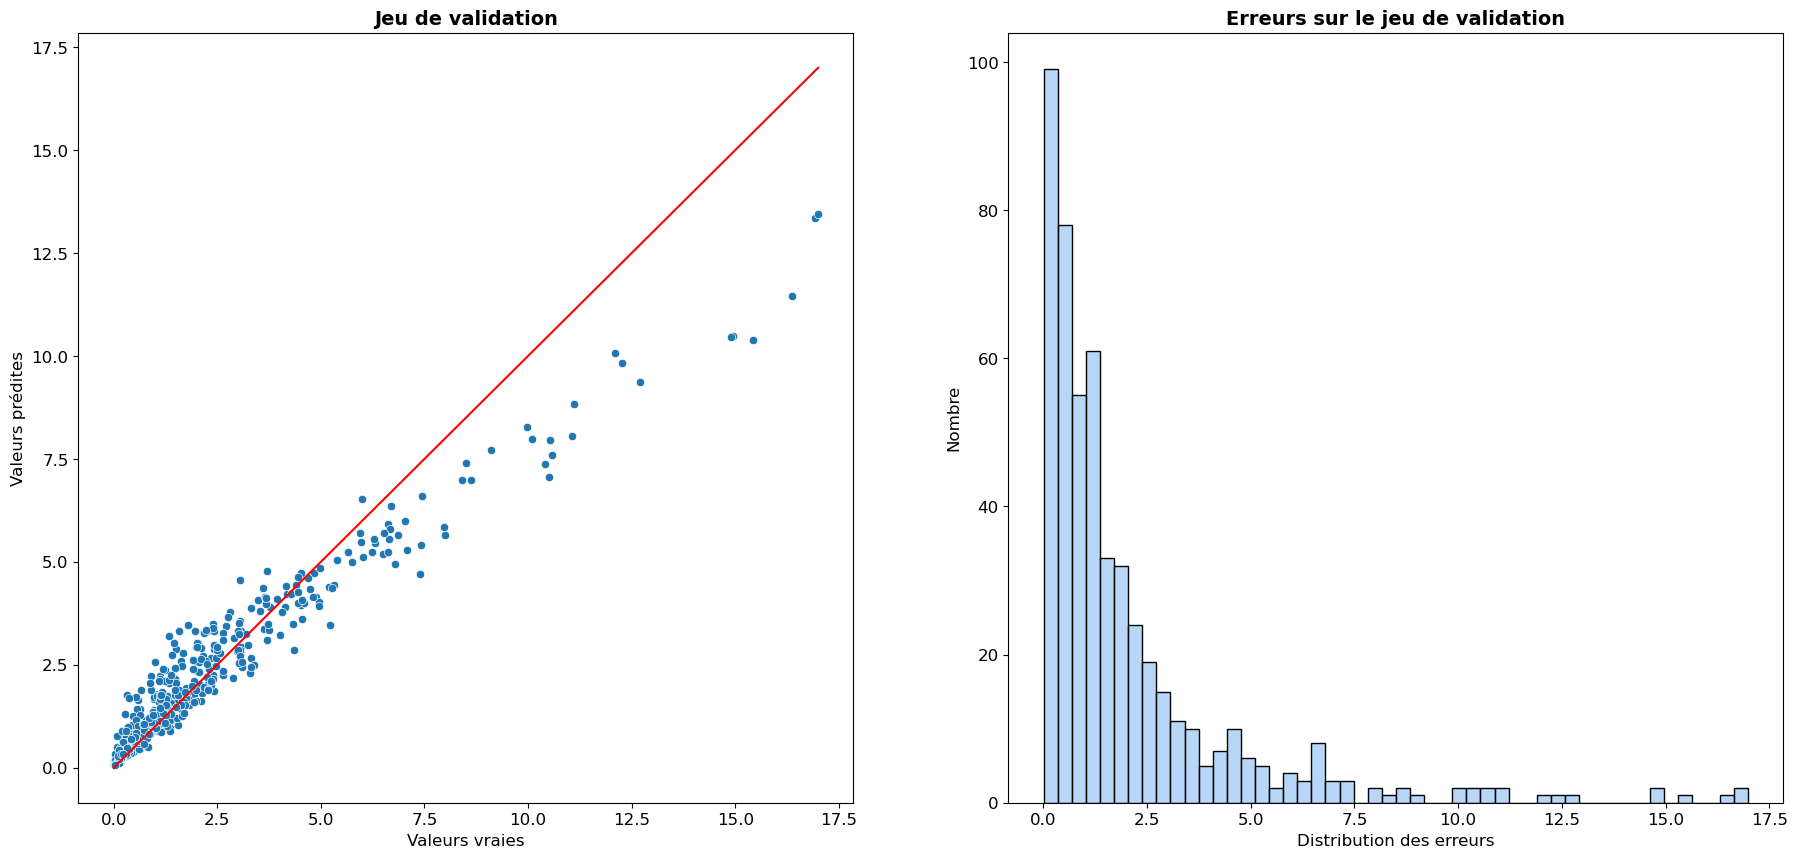

In [67]:
errors_val = np.abs(y_val, y_pred_val)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (22,10))
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax=axes[0], data=data_plot, x='y_vrai', y= 'y_predit')
    sns.lineplot(ax=axes[0], x=np.linspace(0, 17, 50), y=np.linspace(0, 17, 50), color='r')
    axes[0].set_xlabel("Valeurs vraies", fontname = 'sans-serif', fontsize = 12)
    axes[0].set_ylabel("Valeurs prédites", fontname = 'sans-serif', fontsize = 12)
    axes[0].set_title("Jeu de validation", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    sns.histplot(ax=axes[1], x=errors_val, bins=50)
    axes[1].set_xlabel("Distribution des erreurs", fontname = 'sans-serif', fontsize = 12)
    axes[1].set_ylabel("Nombre", fontname = 'sans-serif', fontsize = 12)
    axes[1].set_title("Erreurs sur le jeu de validation", fontname = 'sans-serif', fontsize = 14, fontweight = "bold")
    
plt.show()

**La performance de notre modèle est d'environ 90% avec un pourcentage d'erreurs avoisinant les 10%, ce qui en soit me semble pertinent vu la quantité de données à disposition pour l'apprentissage. Lorsque nous observons la distribution des erreurs, nous pouvons remarquer que nous avons la majorité des erreurs qui sont de faible ampleur. Le modèle apprend bien mais présente des difficultés pour généraliser surtout les valeurs importantes. Afin d'avoir un modèle plus robuste, il faudrait fournir davantage de données pour l'apprentissage ce qui est impossible dans notre cas.**

### CONCLUSION

- **Intérêt non négligeable de l'incorporation de l'Energy Star Score, même si cela induit un travail fastidieux.**
- **Meilleure capacité pour la prédiction de nouvelles données comparativement au modèle de prédiction de la consommation en énergie.**
- **Intérêt non négligeable malgré le coût d'effectuer davantage de relevés afin d'obtenir un modèle davantage robuste.**